# STEP B

In [14]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

def read_image_and_compute_keypoints(object_imgs, scene_imgs, detector):
    imgs_dict = {}

    for name_img in object_imgs:
        img_load = cv2.imread('models/' + name_img + '.jpg', cv2.IMREAD_GRAYSCALE)
        
        """
        # Enlever le centre de l'image
        row = int(img_load.shape[0]/2)
        col = int(img_load.shape[1]/2)
        pour = 0.5
        new_color = 255 # White
        img_load[int(row - row*pour) : int(row + row*pour), int(col - col*pour): int(col + col*pour)] = new_color
        #
        """

        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

    for name_img in scene_imgs:
        img_load = cv2.imread('scenes/' + name_img + '.png', cv2.IMREAD_GRAYSCALE)
        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

    return imgs_dict

def matching_and_localize_objects_in_scene(imgs_dict, name_scene_img, ratio_test=0.45):
    all_scene_corners = {}
    all_good ={}
    for name in object_imgs:
        object_des, object_kp = imgs_dict[name]['des'], imgs_dict[name]['kp']
        scene_des, scene_kp = imgs_dict[name_scene_img]['des'], imgs_dict[name_scene_img]['kp']
        
        #-- matching
        matches = matcher.knnMatch(object_des, scene_des, k=2)
    
        #-- store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < ratio_test*n.distance:
                good.append(m)
                
        if len(good) > 30:        
            #-- Get the keypoints from the good matches
            object_good_kp = np.float32([ object_kp[m.queryIdx].pt for m in good ])
            scene_good_kp = np.float32([ scene_kp[m.trainIdx].pt for m in good ])   


            #-- Get the corners of object
            h,w = imgs_dict[name]['shape'][0:2]
            object_corners = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            #-- Get the homography of object/scene
            H, _ =  cv2.findHomography(object_good_kp, scene_good_kp, cv2.RANSAC, 5.0)

            #-- Get the corners of object in scene
            scene_corners = cv2.perspectiveTransform(object_corners, H)


            all_scene_corners[name] = scene_corners
            all_good[name] = good
        
    return all_scene_corners, all_good

def check_best_color_matches(all_scene_corners, name_scene_img):
    
    scene_img_bgr = cv2.imread('scenes/' + name_scene_img + '.png')
    best_all_scene_corners = {}
    
    for name in all_scene_corners.keys():

        x_min = max(int(np.min(all_scene_corners[name], axis=0)[0][0]), 0)
        y_min = max(int(np.min(all_scene_corners[name], axis=0)[0][1]), 0)
        x_max = int(np.max(all_scene_corners[name], axis=0)[0][0])
        y_max = int(np.max(all_scene_corners[name], axis=0)[0][1])
        
        object_img_bgr = cv2.imread('models/' + name + '.jpg')
        
        object_img_mean_color = object_img_bgr.mean(axis=0).mean(axis=0)
        object_in_scene_img = scene_img_bgr[y_min:y_max,x_min:x_max]
        object_in_scene_img_mean_color = object_in_scene_img.mean(axis=0).mean(axis=0)   
        color_diff = np.sqrt(np.sum([value ** 2 for value in abs(object_img_mean_color - object_in_scene_img_mean_color)]))
        
        #color_diff = (np.sum([value **2 for value in (object_img_mean_color - object_in_scene_img_mean_color)]))/4
        
        if color_diff < 60:
            best_all_scene_corners[name] = all_scene_corners[name]
        
    return best_all_scene_corners

def drawn_object_lines_in_scene(img_scene, best_all_scene_corners):
    for name in best_all_scene_corners.keys():
        scene_corners = best_all_scene_corners[name]
        img_scene = cv2.polylines(img_scene, [np.int32(scene_corners)], 
                                  isClosed=True, color=(0,255,0), thickness=5)
    return img_scene

def print_object_found(best_all_scene_corners):
    for name in best_all_scene_corners.keys():  
        x_min = max(int(np.min(best_all_scene_corners[name], axis=0)[0][0]), 0)
        y_min = max(int(np.min(best_all_scene_corners[name], axis=0)[0][1]), 0)
        x_max = int(np.max(best_all_scene_corners[name], axis=0)[0][0])
        y_max = int(np.max(best_all_scene_corners[name], axis=0)[0][1])
        
        print('Product {} - {} instance/s found:'.format(name, 1))
        print('\tInstance {} position: {}, width: {}px, height: {}px'.format(1, (x_min, y_min), (x_max-x_min), (y_max-y_min)))
    
    print('_' * 80 + '\n')

def stepA():
    
    detector = cv2.SIFT_create()
    FLANN_INDEX_KDTREE = 1

        # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

        # Defining search params.
        # checks=50 specifies the number of times the trees in the index should be recursively traversed.
        # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

        # Initializing matcher
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    #matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    
    imgs_dict = read_image_and_compute_keypoints(object_imgs, scene_imgs, detector)
    
    
    for scene_name in scene_imgs:
        
        all_scene_corners, all_good= matching_and_localize_objects_in_scene(imgs_dict, scene_name)
        
        best_all_scene_corners = check_best_color_matches(all_scene_corners , scene_name)
        
        
        img_scene_rgb = cv2.cvtColor(cv2.imread('scenes/' + scene_name + '.png'), cv2.COLOR_BGR2RGB)
        img_scene_rgb = drawn_object_lines_in_scene(img_scene_rgb, best_all_scene_corners)

        
        print('Scene {} :'.format(scene_name))
        plt.imshow(img_scene_rgb)
        plt.show()
        print_object_found(best_all_scene_corners)

In [73]:
#-- bank of image step B
object_imgs = ['0', '1', '11', '19', '24', '25', '26']
#object_imgs = ['0', '11']
scene_imgs = ['m1', 'm2', 'm3', 'm4', 'm5']

detector = cv2.SIFT_create()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
matcher = cv2.FlannBasedMatcher(index_params, search_params)

In [74]:
imgs_dict = read_image_and_compute_keypoints(object_imgs, scene_imgs, detector)

In [75]:
imgs_dict

{'0': {'kp': [<KeyPoint 0x7fd89acef1b0>,
   <KeyPoint 0x7fd89acef3f0>,
   <KeyPoint 0x7fd89b866240>,
   <KeyPoint 0x7fd89b38e330>,
   <KeyPoint 0x7fd89b552a80>,
   <KeyPoint 0x7fd89b5521b0>,
   <KeyPoint 0x7fd89b5524e0>,
   <KeyPoint 0x7fd89b5523f0>,
   <KeyPoint 0x7fd89ada9480>,
   <KeyPoint 0x7fd89ada9f30>,
   <KeyPoint 0x7fd89b59d4b0>,
   <KeyPoint 0x7fd898dbdde0>,
   <KeyPoint 0x7fd89b39f5a0>,
   <KeyPoint 0x7fd89b39fc60>,
   <KeyPoint 0x7fd89b39f5d0>,
   <KeyPoint 0x7fd89ad6b420>,
   <KeyPoint 0x7fd89ad6b7b0>,
   <KeyPoint 0x7fd89b48dc30>,
   <KeyPoint 0x7fd89b48d150>,
   <KeyPoint 0x7fd89b48d480>,
   <KeyPoint 0x7fd89b3adb40>,
   <KeyPoint 0x7fd89b3ad360>,
   <KeyPoint 0x7fd89b3adf60>,
   <KeyPoint 0x7fd89b3ad930>,
   <KeyPoint 0x7fd89b3ad720>,
   <KeyPoint 0x7fd89b3adb70>,
   <KeyPoint 0x7fd89b3ade10>,
   <KeyPoint 0x7fd89b3adc90>,
   <KeyPoint 0x7fd89b3adb10>,
   <KeyPoint 0x7fd89b3ad9c0>,
   <KeyPoint 0x7fd89b3ad990>,
   <KeyPoint 0x7fd89b3ad750>,
   <KeyPoint 0x7fd89b3adf00>,

In [76]:
#for name in object_imgs:
object_des, object_kp = imgs_dict['24']['des'], imgs_dict['24']['kp']
scene_des, scene_kp = imgs_dict['m1']['des'], imgs_dict['m1']['kp']

#-- matching
matches = matcher.knnMatch(object_des, scene_des, k=2)

#-- store all the good matches as per Lowe's ratio test.
goodIdx = {}
for m,n in matches:
    if m.distance < 0.5*n.distance:
        goodIdx[m.trainIdx] = m.queryIdx

good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append(m)


good_kp = {}
for m in good:
    good_kp[scene_kp[m.trainIdx]] = object_kp[m.queryIdx]

#-- barycenter of found object keypoint
object_xc = np.mean([ kp.pt[0] for kp in good_kp.values() ], dtype='float')
object_yc = np.mean([ kp.pt[1] for kp in good_kp.values() ], dtype='float')

# create hough space 
hough_space = {}

In [77]:
object_xc

142.59595560765527

In [78]:
for scene_kp, object_kp in good_kp.items():

    
    entry = {}

    v = ((object_xc - object_kp.pt[0]), (object_yc - object_kp.pt[1]))
    ratio_of_size = scene_kp.size / object_kp.size
    relative_angle = scene_kp.angle - object_kp.angle
    x_c = scene_kp.pt[0] + ratio_of_size * (np.cos(relative_angle) * v[0] - np.sin(relative_angle) * v[1])
    y_c = scene_kp.pt[1] + ratio_of_size * (np.sin(relative_angle) * v[0] + np.cos(relative_angle) * v[1])

    entry['x_c'] = x_c
    entry['y_c'] = y_c
    entry['ratio_of_size'] = ratio_of_size
    entry['relative_angle'] = relative_angle

    hough_space[(object_kp, scene_kp)] = entry

        
        
        

In [79]:
entry

{'x_c': 1202.8534339995979,
 'y_c': 201.17800227303175,
 'ratio_of_size': 1.3863444711983242,
 'relative_angle': -319.1788635253906}

In [80]:
hough_space

{(<KeyPoint 0x7fd899246d50>,
  <KeyPoint 0x7fd89ac0d270>): {'x_c': 357.65379843735343, 'y_c': 316.24970965803254, 'ratio_of_size': 1.1341718671903613, 'relative_angle': 1.088531494140625},
 (<KeyPoint 0x7fd89924c060>,
  <KeyPoint 0x7fd89ac0d660>): {'x_c': 220.24339649025706, 'y_c': 141.25258812047352, 'ratio_of_size': 1.2904142893616906, 'relative_angle': -3.93072509765625},
 (<KeyPoint 0x7fd89924c930>,
  <KeyPoint 0x7fd89af295a0>): {'x_c': 106.97250853941227, 'y_c': -64.40734270888476, 'ratio_of_size': 1.4659271088418622, 'relative_angle': -2.2049102783203125},
 (<KeyPoint 0x7fd89924cae0>,
  <KeyPoint 0x7fd89af29c30>): {'x_c': 20.63726128208534, 'y_c': 265.1774539880048, 'ratio_of_size': 1.13764346169738, 'relative_angle': -7.4033203125},
 (<KeyPoint 0x7fd899249060>,
  <KeyPoint 0x7fd89ac040f0>): {'x_c': 557.3118146206871, 'y_c': 251.65802294325223, 'ratio_of_size': 1.158615381083558, 'relative_angle': -0.297210693359375},
 (<KeyPoint 0x7fd8992492d0>,
  <KeyPoint 0x7fd89af150c0>): {'x

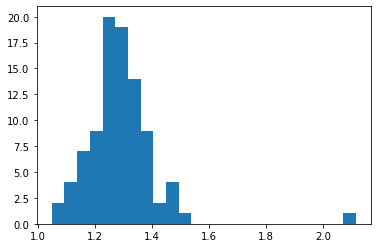

In [82]:
#compute_bins(hough_space,query_shape,train_shape):

values = {}

list_ratio_of_size = [entry['ratio_of_size'] for entry in hough_space.values()]
counts_scale, bins_scale, patches_size = plt.hist(list_ratio_of_size, bins='auto')
img_scale = np.mean([bins_scale[np.argmax(counts_scale)], bins_scale[np.argmax(counts_scale) + 1]])
#plt.close();

In [87]:
bins_scale

array([1.04979956, 1.09419943, 1.13859929, 1.18299915, 1.22739901,
       1.27179887, 1.31619874, 1.3605986 , 1.40499846, 1.44939832,
       1.49379818, 1.53819805, 1.58259791, 1.62699777, 1.67139763,
       1.71579749, 1.76019736, 1.80459722, 1.84899708, 1.89339694,
       1.9377968 , 1.98219667, 2.02659653, 2.07099639, 2.11539625])

In [72]:
img_scale

1.2495989438048436

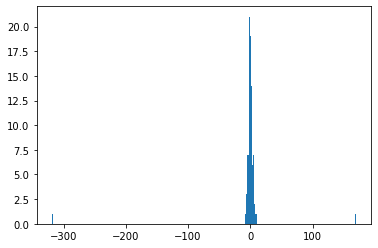

In [88]:
list_relative_angle = [entry['relative_angle'] for entry in hough_space.values()]
counts_angle, bins_angle, patches_angle = plt.hist(data_angle, bins='auto')
#plt.close();

In [89]:
BIN_PRECISION_FACTOR = 0.25
ANGLE_BINS = 7
ANGLE_BIN_SIZE_COEFF = 0.1
SCALE_BIN_SIZE_COEFF = 0.1

object_shape = imgs_dict['24']['shape']
scene_shape = imgs_dict['m1']['shape']

x_bin_size = img_scale * object_shape[1] * BIN_PRECISION_FACTOR
y_bin_size = img_scale * object_shape[0] * BIN_PRECISION_FACTOR
x_bins = int(np.ceil(scene_shape[1] / x_bin_size) + 2)
y_bins = int(np.ceil(scene_shape[0] / y_bin_size) + 2)
x_min = scene_shape[1] / 2 - x_bins / 2 * x_bin_size
y_min = scene_shape[0] / 2 - y_bins / 2 * y_bin_size

angle_bin_size = np.std(list_relative_angle) * ANGLE_BIN_SIZE_COEFF
angle_bin_center = np.mean(list_relative_angle)
angle_min = angle_bin_center - ANGLE_BINS / 2 * angle_bin_size
angle_max = angle_bin_center + ANGLE_BINS / 2 * angle_bin_size

scale_bin_size = np.std(list_ratio_of_size) * SCALE_BIN_SIZE_COEFF
scale_bin_center = np.mean(list_ratio_of_size)
scale_min = 0 
scale_max = scale_bin_center * 2 
scale_bins = int((scale_max - scale_min) / scale_bin_size)

bins_values = {}
bins_values['x_bins'] = x_bins
bins_values['y_bins'] = y_bins
bins_values['x_min'] = x_min
bins_values['y_min'] = y_min
bins_values['x_bin_size'] = x_bin_size
bins_values['y_bin_size'] = y_bin_size
bins_values['scale_bins'] = scale_bins
bins_values['scale_min'] = scale_min
bins_values['scale_bin_size'] = scale_bin_size
bins_values['angle_min'] = angle_min
bins_values['angle_bin_size'] = angle_bin_size  

    #return values

In [90]:
bins_values

{'x_bins': 19,
 'y_bins': 6,
 'x_min': -89.30532271485606,
 'y_min': -129.19609343935588,
 'x_bin_size': 84.34792870682695,
 'y_bin_size': 120.89869781311862,
 'scale_bins': 207,
 'scale_min': 0,
 'scale_bin_size': 0.012439406331558295,
 'angle_min': -14.851268512925186,
 'angle_bin_size': 3.802936918150941}

In [30]:
accumulator = np.zeros((bins_values['x_bins'], bins_values['y_bins'], ANGLE_BINS, bins_values['scale_bins']))

votes = {}

for kps, v in hough_space.items():
    try:
        for x in range(0, 2):
            for y in range(0, 2):
                for z in range(0, 2):
                    for w in range(0, 2):                
                        i = int(np.floor((v['x_c'] - bins_values['x_min'] + (x - 1 / 2) * bins_values['x_bin_size']) / bins_values['x_bin_size']))
                        j = int(np.floor((v['y_c'] - bins_values['y_min'] + (y - 1 / 2) * bins_values['y_bin_size']) / bins_values['y_bin_size']))
                        k = int(np.floor((v['delta_angle'] - bins_values['angle_min'] + (z - 1 / 2) * bins_values['angle_bin_size']) / bins_values['angle_bin_size']))
                        l = int(np.floor((v['scale_ratio'] - bins_values['scale_min'] + (w - 1 / 2) * bins_values['scale_bin_size']) / bins_values['scale_bin_size']))
                        if i >= 0 and j >= 0 and k >= 0 and l >= 0:
                            accumulator[i, j, k, l] += 1
                            votes[(i, j, k, l)] = votes.get((i, j, k, l), [])
                            votes[(i, j, k, l)].append(kps)
    except: pass

In [53]:
accumulator.shape

(19, 6, 7, 210)

In [31]:
votes

{(2, 3, 3, 104): [(<KeyPoint 0x7fd8967ed510>, <KeyPoint 0x7fd896b1f360>)],
 (2, 3, 3, 105): [(<KeyPoint 0x7fd8967ed510>, <KeyPoint 0x7fd896b1f360>),
  (<KeyPoint 0x7fd8967f4d80>, <KeyPoint 0x7fd896b24f90>)],
 (2, 3, 4, 104): [(<KeyPoint 0x7fd8967ed510>, <KeyPoint 0x7fd896b1f360>)],
 (2, 3, 4, 105): [(<KeyPoint 0x7fd8967ed510>, <KeyPoint 0x7fd896b1f360>),
  (<KeyPoint 0x7fd8967f4d80>, <KeyPoint 0x7fd896b24f90>)],
 (2, 4, 3, 104): [(<KeyPoint 0x7fd8967ed510>, <KeyPoint 0x7fd896b1f360>)],
 (2, 4, 3, 105): [(<KeyPoint 0x7fd8967ed510>, <KeyPoint 0x7fd896b1f360>),
  (<KeyPoint 0x7fd8967f4d80>, <KeyPoint 0x7fd896b24f90>)],
 (2, 4, 4, 104): [(<KeyPoint 0x7fd8967ed510>, <KeyPoint 0x7fd896b1f360>),
  (<KeyPoint 0x7fd8967f7960>, <KeyPoint 0x7fd896b26f30>)],
 (2, 4, 4, 105): [(<KeyPoint 0x7fd8967ed510>, <KeyPoint 0x7fd896b1f360>),
  (<KeyPoint 0x7fd8967f4d80>, <KeyPoint 0x7fd896b24f90>),
  (<KeyPoint 0x7fd8967f7960>, <KeyPoint 0x7fd896b26f30>)],
 (3, 3, 3, 104): [(<KeyPoint 0x7fd8967ed510>, <KeyPo

In [56]:
accumulator

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 

In [33]:
import skimage.morphology as sk

In [34]:
mask = sk.local_maxima(accumulator)

In [35]:
mask.shape

(19, 6, 7, 210)

In [36]:
accumulator[mask != 1] = 0

In [37]:
T_Q = 5
global_correspondences = []

for b in list(np.argwhere(accumulator >= T_Q)): # thresholding the accumulator to come up with few maxima 
    keypoint_correspondance_list = votes[tuple(b)] # all query keypoint who voted for a local maxima bin 
    global_correspondences.append([accumulator[tuple(b)], '24', keypoint_correspondance_list])

In [59]:
votes[tuple([  7,   3,   3, 102])]

[(<KeyPoint 0x7fd8967f03c0>, <KeyPoint 0x7fd896b2a600>),
 (<KeyPoint 0x7fd8967f0f00>, <KeyPoint 0x7fd896b2ac90>),
 (<KeyPoint 0x7fd8967f1ba0>, <KeyPoint 0x7fd896b2b480>),
 (<KeyPoint 0x7fd8967f3b10>, <KeyPoint 0x7fd896b2c930>),
 (<KeyPoint 0x7fd8967f3d20>, <KeyPoint 0x7fd896b2cc00>),
 (<KeyPoint 0x7fd8967f4300>, <KeyPoint 0x7fd896b2cd80>),
 (<KeyPoint 0x7fd8967f4ab0>, <KeyPoint 0x7fd896b2d4b0>)]

In [62]:
accumulator[tuple([  7,   3,   3, 102])]

7.0

In [40]:
np.argwhere(accumulator >= T_Q)

array([[  7,   3,   3, 102],
       [  7,   3,   4, 102]])

In [41]:
global_correspondences

[[7.0,
  '24',
  [(<KeyPoint 0x7fd8967f03c0>, <KeyPoint 0x7fd896b2a600>),
   (<KeyPoint 0x7fd8967f0f00>, <KeyPoint 0x7fd896b2ac90>),
   (<KeyPoint 0x7fd8967f1ba0>, <KeyPoint 0x7fd896b2b480>),
   (<KeyPoint 0x7fd8967f3b10>, <KeyPoint 0x7fd896b2c930>),
   (<KeyPoint 0x7fd8967f3d20>, <KeyPoint 0x7fd896b2cc00>),
   (<KeyPoint 0x7fd8967f4300>, <KeyPoint 0x7fd896b2cd80>),
   (<KeyPoint 0x7fd8967f4ab0>, <KeyPoint 0x7fd896b2d4b0>)]],
 [7.0,
  '24',
  [(<KeyPoint 0x7fd8967f03c0>, <KeyPoint 0x7fd896b2a600>),
   (<KeyPoint 0x7fd8967f0f00>, <KeyPoint 0x7fd896b2ac90>),
   (<KeyPoint 0x7fd8967f1ba0>, <KeyPoint 0x7fd896b2b480>),
   (<KeyPoint 0x7fd8967f3b10>, <KeyPoint 0x7fd896b2c930>),
   (<KeyPoint 0x7fd8967f3d20>, <KeyPoint 0x7fd896b2cc00>),
   (<KeyPoint 0x7fd8967f4300>, <KeyPoint 0x7fd896b2cd80>),
   (<KeyPoint 0x7fd8967f4ab0>, <KeyPoint 0x7fd896b2d4b0>)]]]

In [42]:
global_correspondences[1]

[7.0,
 '24',
 [(<KeyPoint 0x7fd8967f03c0>, <KeyPoint 0x7fd896b2a600>),
  (<KeyPoint 0x7fd8967f0f00>, <KeyPoint 0x7fd896b2ac90>),
  (<KeyPoint 0x7fd8967f1ba0>, <KeyPoint 0x7fd896b2b480>),
  (<KeyPoint 0x7fd8967f3b10>, <KeyPoint 0x7fd896b2c930>),
  (<KeyPoint 0x7fd8967f3d20>, <KeyPoint 0x7fd896b2cc00>),
  (<KeyPoint 0x7fd8967f4300>, <KeyPoint 0x7fd896b2cd80>),
  (<KeyPoint 0x7fd8967f4ab0>, <KeyPoint 0x7fd896b2d4b0>)]]

In [43]:
h,w = imgs_dict['24']['shape'][0:2]
object_corners = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

entry = global_correspondences[1]
src_pts = np.float32([e[0].pt for e in entry[2]]).reshape(-1, 1, 2)
dst_pts = np.float32([e[1].pt for e in entry[2]]).reshape(-1, 1, 2)
H, _ =  cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


scene_corners = cv2.perspectiveTransform(object_corners, H)

In [44]:
entry

[7.0,
 '24',
 [(<KeyPoint 0x7fd8967f03c0>, <KeyPoint 0x7fd896b2a600>),
  (<KeyPoint 0x7fd8967f0f00>, <KeyPoint 0x7fd896b2ac90>),
  (<KeyPoint 0x7fd8967f1ba0>, <KeyPoint 0x7fd896b2b480>),
  (<KeyPoint 0x7fd8967f3b10>, <KeyPoint 0x7fd896b2c930>),
  (<KeyPoint 0x7fd8967f3d20>, <KeyPoint 0x7fd896b2cc00>),
  (<KeyPoint 0x7fd8967f4300>, <KeyPoint 0x7fd896b2cd80>),
  (<KeyPoint 0x7fd8967f4ab0>, <KeyPoint 0x7fd896b2d4b0>)]]

In [45]:
scene_corners

array([[[385.35132 ,  -8.876926]],

       [[391.65033 , 457.60294 ]],

       [[727.9135  , 469.1335  ]],

       [[723.1984  , -37.5151  ]]], dtype=float32)

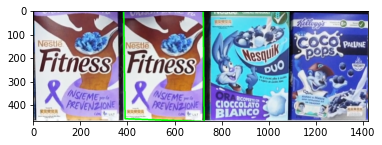

In [46]:
img_scene = cv2.imread('scenes/m1.png')
img_scene = cv2.polylines(img_scene, [np.int32(scene_corners)], isClosed=True, color=(0,255,0), thickness=5)
plt.imshow(img_scene)

In [67]:
# function that split an image into (n_bins_heigth x n_bins_width) bins and returns a dictonary
# that contains the means of the 3 color channels of the (n_bins_heigth x n_bins_width) bins
def split_image_into_N_x_M_bins_with_intensity_means(image, n_bins_width = 3, n_bins_heigth = 4):
    img_N_x_M_bins = {}
    
    img2 = np.copy(image)
    
    img_width = image.shape[1]
    img_height = image.shape[0]
    
    step_width = int(img_width / n_bins_width)
    step_height = int(img_height / n_bins_heigth)
    
    r = 0
    c = 0
    
    #print('img_height: ', img_height)
    #print('step_height: ', step_height)
    if img_height != 0 and step_height != 0 and img_width != 0 and step_width != 0:
        for row in np.arange(0, img_height, step_height):
            c = 0
            cv2.line(img2,(0, row),(img_width, row),(0,0,0),3) 
            for col in np.arange(0, img_width, step_width):
                # print('row {} col {}'.format(r,c))
                if row + 2 * step_height > img_height and col + 2 * step_width > img_width:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(image[row:, col:])

                elif row + 2 * step_height > img_height:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(image[row:, col : col + step_width])

                elif col + 2 * step_width > img_width:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(image[row : row + step_height, col :])
                else:
                    partial_r_channel, partial_g_channel, partial_b_channel = cv2.split(
                        image[row : row + step_height, col : col + step_width])

                cv2.line(img2,(col, 0),(col, img_height),(0,0,0),3) 
                if r < n_bins_heigth and c < n_bins_width:
                    # save means of the 3 channels (r,g,b) of each bin
                    img_N_x_M_bins[r, c] = (np.mean(partial_r_channel), np.mean(partial_g_channel), np.mean(partial_b_channel))
                    # IF YOU WANT TO VISUALIZE EACH BIN UNCOMMENT THE FOLLOWING LINES:
                    # plot each bin in blue channel color
                    plt.imshow(cv2.cvtColor(partial_b_channel, cv2.COLOR_BGR2RGB))
                    plt.show()


                c += 1
            r += 1
        #plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        #plt.show()  
    return img_N_x_M_bins

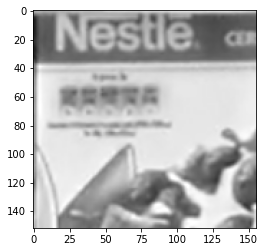

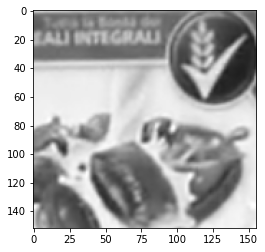

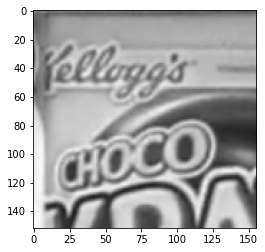

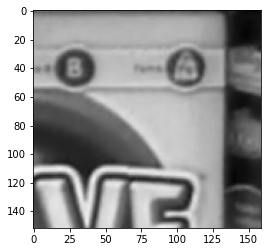

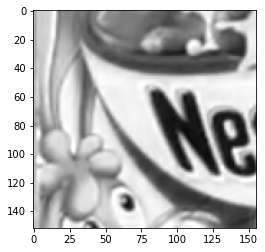

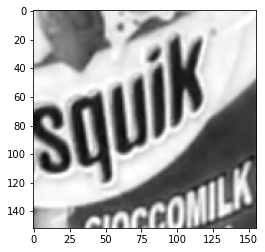

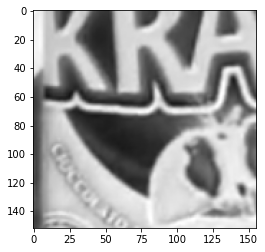

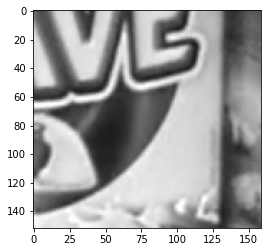

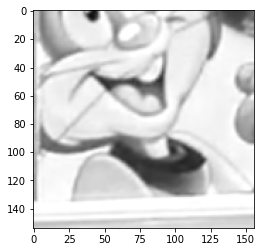

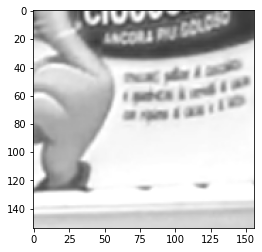

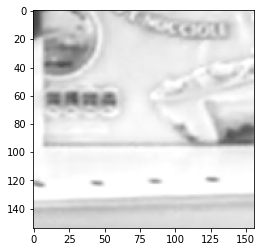

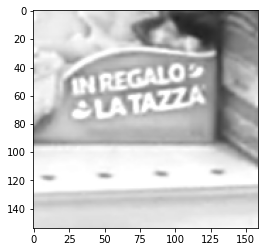

{(0, 0): (103.95664642375169, 166.54234143049933, 178.53572031039135),
 (0, 1): (105.50295209176788, 151.66131072874495, 159.75177125506073),
 (0, 2): (82.32595310391363, 115.17134784075573, 156.28685897435898),
 (0, 3): (72.28748758689176, 93.62752399867594, 133.46747765640515),
 (1, 0): (125.32721828609986, 145.26518218623482, 163.2204790823212),
 (1, 1): (147.67240215924426, 156.18450573549256, 156.62390350877192),
 (1, 2): (74.92615553306342, 115.70196524966262, 154.21221322537113),
 (1, 3): (63.42523171135386, 103.4161287653095, 151.48022178086725),
 (2, 0): (140.502331002331, 184.63598901098902, 208.72668997668998),
 (2, 1): (122.2990342990343, 185.56472693972694, 202.08949383949383),
 (2, 2): (144.96449383949383, 185.1451465201465, 223.2688145188145),
 (2, 3): (137.9247325002042, 146.85081270930328, 198.00792289471534)}

In [70]:
img = cv2.imread('scenes/e1.png')
split_image_into_N_x_M_bins_with_intensity_means(img, 4, 3)

In [65]:
bins_values

{'x_bins': 19,
 'y_bins': 6,
 'x_min': -89.30532271485606,
 'y_min': -129.19609343935588,
 'x_bin_size': 84.34792870682695,
 'y_bin_size': 120.89869781311862,
 'scale_bins': 210,
 'scale_min': 0,
 'scale_bin_size': 0.012292177263818345,
 'angle_min': -14.673104469390008,
 'angle_bin_size': 3.7824873292601597}